In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
# https://github.com/danijar/sets/tree/master/sets/dataset
import sets
# if 'ImportError: cannot import name bayesflow' try $ pip install --upgrade dask
# if 'AttributeError: 'module' object has no attribute 'Ocr'' try $ pip install set

In [2]:
print(tf.__version__)
print(np.__version__)

1.4.0
1.13.3


Objective is to train an LSTM to recognize handwritten characters inputted as a fixed length sequence of characters. 

In [3]:
# The utility functions and datasets were sourced from:https://github.com/danijar/sets/tree/master/sets/dataset
# IMPORTANT: You will need python3 to run. If you need python3 in your jupyter notebook, try the below.
# $ python3 -m pip install ipykernel
# $ python3 -m ipykernel install --user

def read_dataset():
    """
    Dataset of handwritten words collected by Rob Kassel at the MIT Spoken
    Language Systems Group. Each example contains the normalized letters of the
    word, padded to the maximum word length. Only contains lower case letter,
    capitalized letters were removed.
    From: http://ai.stanford.edu/~btaskar/ocr/
    """
    dataset = sets.Ocr()
    dataset = sets.OneHot(dataset.target, depth=2)(dataset, columns=['target'])
    dataset['data'] = dataset.data.reshape(
        dataset.data.shape[:-2] + (-1,)).astype(float)
    train, test = sets.Split(0.66)(dataset)
    return train, test

Quickly assess sample set and dimensions of inputs and targets.

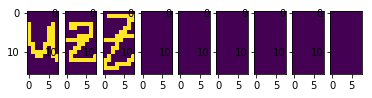

In [4]:
# Get train and test data.
train, test = read_dataset()

data = train.sample(1)
img = data.data
label = data.target

plt.figure()
for i in range(9):
    loc = int("19"+str(i+1))
    plt.subplot(loc)
    plt.imshow(img[0,i].reshape(16,8))

# Note: I am only showing up to 9 when the sequence is really 14 elements long.
# Note: The first letter in the word is removed for consistency on caps or no caps.

In [5]:
print("Input dimension: {}".format(img.shape))
print("Label dimension: {}".format(label.shape))
# Input is 14 steps long, and of size 128 which is flattened image of dimensions 16x8
# There are 27 labels. Note: 26 characters in alphabet. Index 0 is used as indicator for blank
# thus when no character, index 0 will have a value of 1.

Input dimension: (1, 14, 128)
Label dimension: (1, 14, 27)


In [6]:
class RNNModel(object):
    
    def __init__(self,
                 sess,
                 n_units,
                 n_layers,
                 input_size,
                 seq_len,
                 n_classes,
                 p_dropout,
                 batch_size):
        self._sess = sess             # tf session
        self._n_units = n_units       # number of hidden units per layer in RNN
        self._n_layers = n_layers     # number of layers in RNN
        self._seq_len = seq_len       # length of input sequence (a.k.a time step)
        self._n_classes = n_classes   # number of classes (in this case 27)
        self._input_size = input_size # size of input image, (16x8 flattened to 128)
        self._p_drop= p_dropout       # probability of dropout
        self._batch_size = batch_size # batch size for each iteration
        
        # Defined when graph built
        self._dropout = None
        self._inputs = None
        self._target = None 
        self._pred = None
        self._error = None
        # Deine graph
        self._build_graph()
        
    def _model(self, w, b):
        def __cell():
            # https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/python/ops/rnn_cell_impl.py
            # Tensorflow defaults to no peephole LSTM: http://www.bioinf.jku.at/publications/older/2604.pdf
            rnn_cell = tf.contrib.rnn.LSTMCell(self._n_units)
            return tf.contrib.rnn.DropoutWrapper(rnn_cell, output_keep_prob=self._dropout)
        
        cell = tf.contrib.rnn.MultiRNNCell([__cell() for _ in range(self._n_layers)])
        # Out is of dimension [batch_size, max_time, cell_state_size]
        out, state = tf.nn.dynamic_rnn(cell=cell, inputs=self._inputs, dtype=tf.float32)
        out = tf.reshape(out, [-1, self._n_units])
        # Fully connected passthrough to softmax.
        pred = tf.nn.softmax(tf.matmul(out, w) + b)
        return tf.reshape(pred, [-1, self._seq_len, self._n_classes])
        
    def _build_graph(self):
        """ Define graph to run. """
        # Create placeholders
        self._inputs = tf.placeholder(tf.float32, [None, self._seq_len, self._input_size], name="input")
        self._target = tf.placeholder("float", [None,self._seq_len, self._n_classes], name="target")
        self._dropout = tf.placeholder(tf.float32)
        
        # Define variables for final fully connected layer.
        w_ho = tf.Variable(tf.truncated_normal([self._n_units, self._n_classes], stddev=0.01), name="fc_w")
        b_o = tf.Variable(tf.constant(0.1, shape=[self._n_classes]), name="fc_b")
        
        # Create model
        self._pred = self._model(w_ho, b_o)
        
        # Define loss as negative log loss. We want the parameters that minimize this loss function, as we
        # are optimizing to obtain the parameters that best explains the given observations.        
        self._loss = tf.reduce_mean(-tf.reduce_sum(self._target * tf.log(self._pred), [1, 2]), name="loss_nll")
        self._optim = tf.train.RMSPropOptimizer(0.003).minimize(self._loss, name="rmsprop_optim")

        # Use in evaluating accuracy. Gets the index with largest probability found along dim=2.
        # Returns the error rate.
        neq = tf.not_equal(tf.argmax(self._target, 2),tf.argmax(self._pred, 2))
        self._error = tf.reduce_mean(tf.cast(neq, tf.float32))
        
    def _evaluate(self, test_data):
        """ Used in evaluating model with test data
        args: test_data, test data definied in sets.
        """
        test_data_feed = {
            self._inputs: test_data.data,
            self._target: test_data.target,
            self._dropout: 1.0
        }
        return self._sess.run([self._error], test_data_feed)
    
    def train(self, train_data, test_data):
        """ Call to train.
        args: train_data, train object defined in sets.
        args: test_data, test data defined in sets.
        """
        self.writer = tf.summary.FileWriter("./sequence_label_logs")
        self.writer.add_graph(self._sess.graph)
        
        tf.global_variables_initializer().run()
        for epoch in range(10):
            for _ in range(100):
                batch = train_data.sample(self._batch_size)
                train_data_feed = {
                    self._inputs: batch.data,
                    self._target: batch.target,
                    self._dropout: self._p_drop
                }
                train_loss, _ = self._sess.run(
                    [self._loss, self._optim],
                    train_data_feed
                )

            if epoch % 1 == 0:
                error = self._evaluate(test_data)
                print('Epoch {:2d} error {:3.1f}%'.format(epoch + 1, 100 * error[0]))
                

In [7]:
_, seq_len, input_size = train.data.shape
print(train.data.shape)
n_classes = train.target.shape[2]
n_units=100
n_layers=2
p_dropout=0.3
batch_size=10

tf.reset_default_graph()
with tf.Session() as sess:
    model=RNNModel(sess, n_units, n_layers, input_size, seq_len, n_classes, p_dropout, batch_size)
    model.train(train, test)

(4538, 14, 128)
Epoch  1 error 64.2%
Epoch  2 error 57.2%
Epoch  3 error 51.4%
Epoch  4 error 48.0%
Epoch  5 error 47.7%
Epoch  6 error 44.1%
Epoch  7 error 41.7%
Epoch  8 error 39.0%
Epoch  9 error 38.8%
Epoch 10 error 37.5%
